In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

import math
import matplotlib.pyplot as plt

#model
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout, InputLayer
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
#voting
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.ensemble import VotingClassifier
from keras.layers import InputLayer, GRU

Each time I run the Keras, I get different result. - https://github.com/keras-team/keras/issues/2743
- Also running in CPU only mode via os.environ["CUDA_VISIBLE_DEVICES"] = "" I get same issue.

In [2]:
#CPU 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15437405086156065308]

In [3]:
#seed지정 + single thread 사용 => 안됨
import tensorflow as tf
import random

seed_num = 42
np.random.seed(seed_num)
# random.seed(seed_num)
tf.random.set_seed(seed_num)

# from keras import backend as K
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
#                               inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)
# import os
# os.environ['PYTHONHASHSEED']=str(seed_num)
# import os
# # running in CPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Data Load

In [133]:
path = '/project/guri/data/'
label = np.load(path + "2030days_label.npy")

data = np.load(path + "10days_data.npy")
label.shape, data.shape

((7799,), (7799, 10, 4069))

# Model

## RF

In [134]:
data2d = pd.read_csv(path + 'data2d_forposter.csv')
data2d.shape

(7799, 4069)

In [6]:
import random
random.seed(seed_num)

# 80% (6239) 기준으로 split

idx = list(range(len(data2d)))
random.shuffle(idx)

i= round(len(data2d)*0.8)

X_train = data2d.iloc[idx[:i]]
y_train = label[idx[:i]]

X_test = data2d.iloc[idx[i:]]
y_test = label[idx[i:]]

# X_train = data2d[:i]
# y_train = label[:i]


# X_test = data2d[i:]
# y_test = label[i:]


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6239, 4069), (6239,), (1560, 4069), (1560,))

In [115]:
# idx

In [8]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

In [9]:
from sklearn import metrics 
print('정확도 :', metrics.accuracy_score(y_test, y_pred))

정확도 : 0.75


## LSTM

In [135]:
import random
random.seed(seed_num)

# 80% (6239) 기준으로 split

idx = list(range(len(data)))
random.shuffle(idx)

i= round(len(data)*0.8)

X_train = data[idx[:i],:,:]
y_train = np.array(label[idx[:i]])

X_test = data[idx[i:],:,:]
y_test = np.array(label[idx[i:]])

# X_train = data[:i,:,:]
# y_train = np.array(label[:i])

# X_test = data[i:,:,:]
# y_test = np.array(label[i:])


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6239, 10, 4069), (6239,), (1560, 10, 4069), (1560,))

In [155]:
seed_num = 1000

In [156]:
tf.random.set_seed(seed_num)
lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
# lstm.add(LSTM(units=128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.1)))
# lstm.add(LSTM(units=64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.1)))
# lstm.add(LSTM(units=32, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.1)))
# lstm.add(LSTM(units=128, activation='relu', return_sequences=True, kernel_regularizer=l1_l2(l1=0.1, l2=0.01)))
# lstm.add(LSTM(units=64, activation='relu', return_sequences=True, kernel_regularizer=l1_l2(l1=0.1, l2=0.01)))
# lstm.add(LSTM(units=32, activation='tanh', return_sequences=False, kernel_regularizer=l1_l2(l1=0.1, l2=0.01)))
lstm.add(LSTM(units=128, activation='relu', return_sequences=True))
lstm.add(LSTM(units=64, activation='relu', return_sequences=True))
lstm.add(LSTM(units=32, activation='tanh', return_sequences=False))
lstm.add(Dense(units=1))
early_stop = EarlyStopping(monitor='val_acc', patience=100, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= "adam", loss = "binary_crossentropy", metrics=['acc'])
#     lstm.summary()
history = lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=30,  callbacks=[early_stop], shuffle=False)

Epoch 1/30
37/37 [==============================] - 8s 86ms/step - loss: 1.8659 - acc: 0.4591 - val_loss: 0.6654 - val_acc: 0.6167
Epoch 2/30
37/37 [==============================] - 2s 57ms/step - loss: 0.6544 - acc: 0.6154 - val_loss: 0.6031 - val_acc: 0.6756
Epoch 3/30
37/37 [==============================] - 2s 56ms/step - loss: 0.5272 - acc: 0.7490 - val_loss: 0.9126 - val_acc: 0.6942
Epoch 4/30
37/37 [==============================] - 2s 56ms/step - loss: 0.4476 - acc: 0.7920 - val_loss: 1.2982 - val_acc: 0.6808
Epoch 5/30
37/37 [==============================] - 2s 55ms/step - loss: 0.3712 - acc: 0.8376 - val_loss: 1.4837 - val_acc: 0.7103
Epoch 6/30
37/37 [==============================] - 2s 55ms/step - loss: 0.2944 - acc: 0.8903 - val_loss: 1.3120 - val_acc: 0.6994
Epoch 7/30
37/37 [==============================] - 2s 56ms/step - loss: 0.4198 - acc: 0.8217 - val_loss: 1.3142 - val_acc: 0.6526
Epoch 8/30
37/37 [==============================] - 2s 55ms/step - loss: 0.5049 - a

In [157]:
preds = lstm.predict(X_test)

preds[preds>0.5]=1
preds[preds<=0.5]=0

from sklearn import metrics 
print('정확도 :', metrics.accuracy_score(y_test, preds))

정확도 : 0.7416666666666667


In [115]:
preds = lstm.predict(X_test)

preds[preds>0.5]=1
preds[preds<=0.5]=0

from sklearn import metrics 
print('정확도 :', metrics.accuracy_score(y_test, preds))

정확도 : 0.7557692307692307


## plot

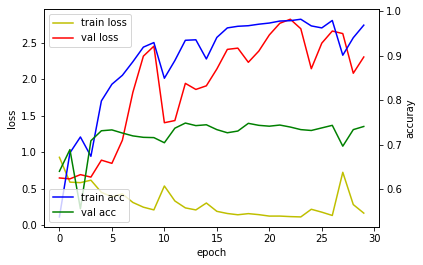

In [13]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# lsh code

In [15]:
lstm2 = Sequential()
lstm2.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm2.add(LSTM(units=512, activation='tanh', return_sequences=True))
lstm2.add(LSTM(units=256, activation='tanh', return_sequences=True))
lstm2.add(LSTM(units=128, activation='tanh', return_sequences=True))
lstm2.add(LSTM(units=64, activation='sigmoid', return_sequences=True))
lstm2.add(LSTM(units=32, activation='sigmoid', return_sequences=False))
lstm2.add(Dense(units=1))
early_stop = EarlyStopping(monitor='val_acc', patience=100, verbose=1, restore_best_weights=True)
lstm2.compile(optimizer= "adam", loss = "binary_crossentropy", metrics=['acc'])
history = lstm2.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=30,  callbacks=[early_stop], shuffle=False)

Epoch 1/30
37/37 [==============================] - 18s 314ms/step - loss: 0.7125 - acc: 0.5625 - val_loss: 0.5783 - val_acc: 0.7019
Epoch 2/30
37/37 [==============================] - 10s 264ms/step - loss: 0.5491 - acc: 0.7345 - val_loss: 0.5453 - val_acc: 0.7160
Epoch 3/30
37/37 [==============================] - 10s 263ms/step - loss: 0.5669 - acc: 0.6980 - val_loss: 0.5953 - val_acc: 0.7071
Epoch 4/30
37/37 [==============================] - 10s 261ms/step - loss: 0.4687 - acc: 0.8134 - val_loss: 0.5371 - val_acc: 0.7404
Epoch 5/30
37/37 [==============================] - 9s 256ms/step - loss: 0.3621 - acc: 0.8623 - val_loss: 0.5550 - val_acc: 0.7603
Epoch 6/30
37/37 [==============================] - 10s 264ms/step - loss: 0.2796 - acc: 0.8957 - val_loss: 0.6892 - val_acc: 0.7526
Epoch 7/30
37/37 [==============================] - 9s 257ms/step - loss: 0.2631 - acc: 0.9202 - val_loss: 0.6751 - val_acc: 0.7372
Epoch 8/30
37/37 [==============================] - 9s 256ms/step - los

In [17]:
preds = lstm2.predict(X_test)

preds[preds>0.5]=1
preds[preds<=0.5]=0

from sklearn import metrics 
print('정확도 :', metrics.accuracy_score(y_test, preds))

정확도 : 0.7403846153846154


# 7799 - 72
- ITEM 값이 모두 0인 사람 72명 제거

In [4]:
path = '/project/LSH/'
label1 = np.load(path + "y_(7727,1).npy")

data1 = np.load(path + "x_(7727,10,4069).npy")
data2d = np.load(path + 'x_(7727,4069).npy')
data2d[data2d>1] = 1

label1.shape, data1.shape, data2d.shape

((7727,), (7727, 10, 4069), (7727, 4069))

In [6]:
# t = pd.DataFrame(data2d.sum(axis=1))
# t[0].value_counts(sort=True, ascending=True)[:10]

In [161]:
import random
random.seed(seed_num)

# 80% (6239) 기준으로 split

idx = list(range(len(data2d)))
random.shuffle(idx)

i= round(len(data2d)*0.8)

X_train = data2d[idx[:i]]
y_train = label[idx[:i]]

X_test = data2d[idx[i:]]
y_test = label[idx[i:]]

# X_train = data2d[:i]
# y_train = label1[:i]


# X_test = data2d[i:]
# y_test = label1[i:]


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 4069), (6182,), (1545, 4069), (1545,))

In [162]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)

from sklearn import metrics 
print('정확도 :', metrics.accuracy_score(y_test, y_pred))

정확도 : 0.6006472491909385


In [6]:
import random
random.seed(seed_num)

path = '/project/LSH/'
label1 = np.load(path + "y_(7727,1).npy")

data1 = np.load(path + "x_(7727,10,4069).npy")
data2d = np.load(path + 'x_(7727,4069).npy')
data2d[data2d>1] = 1

# 80% (6239) 기준으로 split

idx = list(range(len(data1)))
random.shuffle(idx)

i= round(len(data1)*0.8)

X_train1 = data1[idx[:i],:,:]
y_train1 = np.array(label1[idx[:i]])

X_test1 = data1[idx[i:],:,:]
y_test1 = np.array(label1[idx[i:]])


X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((6182, 10, 4069), (6182,), (1545, 10, 4069), (1545,))

In [60]:
seed_num = 42
tf.random.set_seed(seed_num)

# lstm = Sequential()
# lstm.add(InputLayer(input_shape=(X_train1.shape[1],X_train1.shape[2])))
# lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
# lstm.add(Dropout(0.1))
# lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
# lstm.add(Dropout(0.1))
# lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
# lstm.add(Dropout(0.1))
# lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=True))
# lstm.add(Dropout(0.1))
# lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
# lstm.add(Dropout(0.1))
# lstm.add(Dense(units=1, activation='sigmoid'))

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train1.shape[1],X_train1.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))

early_stop = EarlyStopping(monitor='val_acc', patience=30, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= "adam", loss = "binary_crossentropy", metrics=['acc'])
history = lstm.fit(X_train1, y_train1, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop], shuffle=False)

Epoch 1/500
37/37 [==============================] - 8s 81ms/step - loss: 0.6778 - acc: 0.5968 - val_loss: 0.6652 - val_acc: 0.6177
Epoch 2/500
37/37 [==============================] - 2s 53ms/step - loss: 0.6736 - acc: 0.6035 - val_loss: 0.6524 - val_acc: 0.6177
Epoch 3/500
37/37 [==============================] - 2s 53ms/step - loss: 0.6446 - acc: 0.6198 - val_loss: 0.5579 - val_acc: 0.7335
Epoch 4/500
37/37 [==============================] - 2s 53ms/step - loss: 0.6009 - acc: 0.7046 - val_loss: 0.5212 - val_acc: 0.7574
Epoch 5/500
37/37 [==============================] - 2s 53ms/step - loss: 0.4960 - acc: 0.7831 - val_loss: 0.5002 - val_acc: 0.7633
Epoch 6/500
37/37 [==============================] - 2s 53ms/step - loss: 0.4610 - acc: 0.8130 - val_loss: 0.4894 - val_acc: 0.7704
Epoch 7/500
37/37 [==============================] - 2s 53ms/step - loss: 0.4490 - acc: 0.8279 - val_loss: 0.5244 - val_acc: 0.7374
Epoch 8/500
37/37 [==============================] - 2s 53ms/step - loss: 0.

In [61]:
preds = lstm.predict(X_test1)

preds[preds>0.5]=1
preds[preds<=0.5]=0

from sklearn import metrics 
print('정확도 :', metrics.accuracy_score(y_test1, preds))

정확도 : 0.7663430420711974


## BN

In [5]:
from keras.layers import BatchNormalization
from keras.layers import Activation

In [11]:
seed_num = 42
tf.random.set_seed(seed_num)

lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train1.shape[1],X_train1.shape[2])))
lstm.add(LSTM(units=512, return_sequences = True))
lstm.add(BatchNormalization())
lstm.add(Activation('hard_sigmoid'))
lstm.add(LSTM(units=128, return_sequences = True))
lstm.add(BatchNormalization())
lstm.add(Activation('hard_sigmoid'))
lstm.add(LSTM(units=64, return_sequences = True))
lstm.add(BatchNormalization())
lstm.add(Activation('hard_sigmoid'))
lstm.add(LSTM(units=32, return_sequences = True))
lstm.add(BatchNormalization())
lstm.add(Activation('hard_sigmoid'))
lstm.add(LSTM(units=1, return_sequences = False))
lstm.add(BatchNormalization())
lstm.add(Activation('sigmoid'))


early_stop = EarlyStopping(monitor='val_acc', patience=30, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= "adam", loss = "binary_crossentropy", metrics=['acc'])
history = lstm.fit(X_train1, y_train1, validation_split=0.25, batch_size=128, epochs=500,  callbacks=[early_stop], shuffle=False)

Epoch 1/500
37/37 [==============================] - 12s 201ms/step - loss: 0.6595 - acc: 0.6190 - val_loss: 0.6658 - val_acc: 0.6177
Epoch 2/500
37/37 [==============================] - 6s 170ms/step - loss: 0.4922 - acc: 0.7940 - val_loss: 0.6659 - val_acc: 0.6177
Epoch 3/500
37/37 [==============================] - 6s 170ms/step - loss: 0.4311 - acc: 0.8575 - val_loss: 0.6662 - val_acc: 0.6177
Epoch 4/500
37/37 [==============================] - 6s 170ms/step - loss: 0.3893 - acc: 0.8995 - val_loss: 0.6664 - val_acc: 0.6177
Epoch 5/500
37/37 [==============================] - 6s 171ms/step - loss: 0.3547 - acc: 0.9233 - val_loss: 0.6654 - val_acc: 0.6177
Epoch 6/500
37/37 [==============================] - 6s 170ms/step - loss: 0.3287 - acc: 0.9424 - val_loss: 0.6644 - val_acc: 0.6177
Epoch 7/500
37/37 [==============================] - 6s 168ms/step - loss: 0.3087 - acc: 0.9496 - val_loss: 0.6615 - val_acc: 0.6177
Epoch 8/500
37/37 [==============================] - 6s 168ms/step -

In [12]:
preds = lstm.predict(X_test1)

preds[preds>0.5]=1
preds[preds<=0.5]=0

from sklearn import metrics 
print('정확도 :', metrics.accuracy_score(y_test1, preds))

정확도 : 0.7411003236245954


In [180]:
seed_num = 42
tf.random.set_seed(seed_num)
lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train1.shape[1],X_train1.shape[2])))
# lstm.add(LSTM(units=128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.1)))
# lstm.add(LSTM(units=64, activation='relu', return_sequences=True, kernel_regularizer=l2(0.1)))
# lstm.add(LSTM(units=32, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.1)))
# lstm.add(LSTM(units=128, activation='relu', return_sequences=True, kernel_regularizer=l1_l2(l1=0.1, l2=0.01)))
# lstm.add(LSTM(units=64, activation='relu', return_sequences=True, kernel_regularizer=l1_l2(l1=0.1, l2=0.01)))
# lstm.add(LSTM(units=32, activation='tanh', return_sequences=False, kernel_regularizer=l1_l2(l1=0.1, l2=0.01)))
lstm.add(LSTM(units=128, activation='relu', return_sequences=True))
lstm.add(LSTM(units=64, activation='relu', return_sequences=True))
lstm.add(LSTM(units=32, activation='tanh', return_sequences=False))
lstm.add(Dense(units=1))
early_stop = EarlyStopping(monitor='val_acc', patience=100, verbose=1, restore_best_weights=True)
lstm.compile(optimizer= "adam", loss = "binary_crossentropy", metrics=['acc'])
#     lstm.summary()
history = lstm.fit(X_train1, y_train1, validation_split=0.25, batch_size=128, epochs=30,  callbacks=[early_stop], shuffle=False)

Epoch 1/30
37/37 [==============================] - 7s 86ms/step - loss: 1.3221 - acc: 0.4827 - val_loss: 0.6889 - val_acc: 0.5964
Epoch 2/30
37/37 [==============================] - 2s 55ms/step - loss: 0.6164 - acc: 0.6387 - val_loss: 0.5507 - val_acc: 0.7154
Epoch 3/30
37/37 [==============================] - 2s 56ms/step - loss: 0.5119 - acc: 0.7635 - val_loss: 0.7465 - val_acc: 0.7633
Epoch 4/30
37/37 [==============================] - 2s 55ms/step - loss: 0.4645 - acc: 0.8045 - val_loss: 1.1522 - val_acc: 0.7594
Epoch 5/30
37/37 [==============================] - 2s 55ms/step - loss: 0.3702 - acc: 0.8571 - val_loss: 1.3871 - val_acc: 0.7587
Epoch 6/30
37/37 [==============================] - 2s 56ms/step - loss: 0.3152 - acc: 0.8958 - val_loss: 2.2077 - val_acc: 0.7232
Epoch 7/30
37/37 [==============================] - 2s 55ms/step - loss: 0.3534 - acc: 0.8949 - val_loss: 2.4471 - val_acc: 0.7264
Epoch 8/30
37/37 [==============================] - 2s 55ms/step - loss: 0.3037 - a

In [34]:
preds = lstm.predict(X_test1)

preds[preds>0.5]=1
preds[preds<=0.5]=0

from sklearn import metrics 
print('정확도 :', metrics.accuracy_score(y_test1, preds))

정확도 : 0.7313915857605178


In [173]:
preds.sum() / len(preds)

0.6718446601941748

In [ ]:
0.7378640776699029

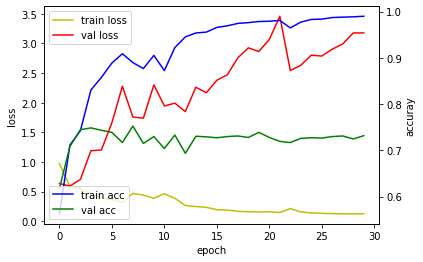

In [112]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# VotingClassifier

In [62]:
path = '/project/LSH/'
label1 = np.load(path + "y_(7727,1).npy")

data1 = np.load(path + "x_(7727,10,4069).npy")
data2d = np.load(path + 'x_(7727,4069).npy')
label1.shape, data1.shape

((7727,), (7727, 10, 4069))

In [63]:
import random
random.seed(seed_num)

# 80% (6239) 기준으로 split

idx = list(range(len(data1)))
random.shuffle(idx)

i= round(len(data1)*0.8)

X_train = data1[idx[:i],:,:]
y_train = np.array(label1[idx[:i]])

X_test = data1[idx[i:],:,:]
y_test = np.array(label1[idx[i:]])


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6182, 10, 4069), (6182,), (1545, 10, 4069), (1545,))

In [68]:
tf.random.set_seed(seed_num)
lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))
lstm.compile(optimizer= "adam", loss = "binary_crossentropy", metrics=['acc'])

In [70]:
%%time
#LSTM 쌓기
estimator = []
for i in range(1,6): #일단 1개로 정확도 측정
    LSTM_Predictors = KerasClassifier(build_fn=lambda:lstm, epochs=20, batch_size=256)
    LSTM_Predictors._estimator_type="classifier"
    estimator.append((f'model{i}', LSTM_Predictors))
print(estimator)    

final_model = VotingClassifier(estimators = estimator, voting = 'soft')
final_model.fit(X_train,y_train)

[('model1', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa538482af0>), ('model2', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa5181dbac0>), ('model3', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa5181db4c0>), ('model4', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa5181db5b0>), ('model5', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa5181dbee0>)]
Epoch 1/20
25/25 [==============================] - 2s 90ms/step - loss: 0.0799 - acc: 0.9811
Epoch 2/20
25/25 [==============================] - 2s 89ms/step - loss: 0.0817 - acc: 0.9799
Epoch 3/20
25/25 [==============================] - 2s 88ms/step - loss: 0.0759 - acc: 0.9841
Epoch 4/20
25/25 [==============================] - 2s 89ms/step - loss: 0.0752 - acc: 0.9833
Epoch 5/20
25/25 [==============================] - 2s 88ms/step - loss: 0.0731 - acc: 0.9838
Epoch 6/20
25/25 [==============================] - 2s 90ms/step - loss: 0.0769 - acc: 0.9819
Epoch 7/20
25/2

VotingClassifier(estimators=[('model1',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa538482af0>),
                             ('model2',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa5181dbac0>),
                             ('model3',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa5181db4c0>),
                             ('model4',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa5181db5b0>),
                             ('model5',
                              <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa5181dbee0>)],
                 voting='soft')

In [71]:
#예측 후 가공
preds = final_model.predict(X_test)

preds[preds>0.5]=1
preds[preds<=0.5]=0

from sklearn import metrics 
print('정확도 :', metrics.accuracy_score(y_test, preds))
# print("RMSE : ", RMSE(y_test, preds))

정확도 : 0.7385113268608414


In [123]:
def get_acc(preds, valid):
    preds[preds>0.5]=1
    preds[preds<=0.5]=0
    return metrics.accuracy_score(valid, preds)

In [126]:
def get_model():
    tf.random.set_seed(seed_num)
    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    lstm.add(LSTM(units=128, activation='relu', return_sequences=True))
    lstm.add(LSTM(units=64, activation='relu', return_sequences=True))
    lstm.add(LSTM(units=32, activation='tanh', return_sequences=False))
    lstm.add(Dense(units=1))
    early_stop = EarlyStopping(monitor='val_acc', patience=100, verbose=1, restore_best_weights=True)
    lstm.compile(optimizer= "adam", loss = "binary_crossentropy", metrics=['acc'])
    return lstm

In [127]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42069)
preds = []
fold = 0
aucs = 0
for train_idx, val_idx in kf.split(X_train):
    x_train_f, y_train_f = X_train[train_idx], y_train[train_idx]
    x_val_f, y_val_f = X_train[val_idx], y_train[val_idx]
    model = get_model()
    model.fit(x_train_f, y_train_f, validation_data=(x_val_f, y_val_f),
              batch_size=128, epochs=30,  callbacks=[early_stop], shuffle=False)

    preds_val = model.predict([x_val_f], batch_size=128) #배치크기를 넣는 이유는? fit batch와 상관이 있는가?
    preds.append(model.predict(X_test1))
    fold+=1

    acc = get_acc(preds_val, y_val_f)
    aucs += acc
    print('Fold {}, ACC = {}'.format(fold, acc))
print("Cross Validation ACC = {}".format(aucs/10))

Epoch 1/30
44/44 [==============================] - 5s 52ms/step - loss: 1.3604 - acc: 0.5042 - val_loss: 0.7169 - val_acc: 0.5784
Epoch 2/30
44/44 [==============================] - 2s 36ms/step - loss: 0.6402 - acc: 0.6425 - val_loss: 0.5848 - val_acc: 0.6914
Epoch 3/30
44/44 [==============================] - 2s 37ms/step - loss: 0.5120 - acc: 0.7467 - val_loss: 0.6801 - val_acc: 0.7496
Epoch 4/30
44/44 [==============================] - 2s 36ms/step - loss: 0.4734 - acc: 0.8008 - val_loss: 1.2488 - val_acc: 0.7754
Epoch 5/30
44/44 [==============================] - 2s 36ms/step - loss: 0.4510 - acc: 0.8397 - val_loss: 1.5276 - val_acc: 0.7577
Epoch 6/30
44/44 [==============================] - 2s 37ms/step - loss: 0.3914 - acc: 0.8761 - val_loss: 1.6761 - val_acc: 0.7302
Epoch 7/30
44/44 [==============================] - 2s 37ms/step - loss: 0.3841 - acc: 0.8799 - val_loss: 2.1293 - val_acc: 0.6931
Epoch 8/30
44/44 [==============================] - 2s 37ms/step - loss: 0.2974 - a

Epoch 3/30
44/44 [==============================] - 2s 36ms/step - loss: 0.5250 - acc: 0.7808 - val_loss: 0.6623 - val_acc: 0.7638
Epoch 4/30
44/44 [==============================] - 2s 37ms/step - loss: 0.4431 - acc: 0.8311 - val_loss: 1.2396 - val_acc: 0.7718
Epoch 5/30
44/44 [==============================] - 2s 36ms/step - loss: 0.3991 - acc: 0.8667 - val_loss: 1.2883 - val_acc: 0.7492
Epoch 6/30
44/44 [==============================] - 2s 36ms/step - loss: 0.4304 - acc: 0.8814 - val_loss: 1.5610 - val_acc: 0.7540
Epoch 7/30
44/44 [==============================] - 2s 36ms/step - loss: 0.3743 - acc: 0.9059 - val_loss: 1.3963 - val_acc: 0.7314
Epoch 8/30
44/44 [==============================] - 2s 36ms/step - loss: 0.3171 - acc: 0.9246 - val_loss: 1.7773 - val_acc: 0.7346
Epoch 9/30
44/44 [==============================] - 2s 36ms/step - loss: 0.2925 - acc: 0.9277 - val_loss: 1.8647 - val_acc: 0.7767
Epoch 10/30
44/44 [==============================] - 2s 37ms/step - loss: 0.2640 - 

Epoch 5/30
44/44 [==============================] - 2s 36ms/step - loss: 0.4145 - acc: 0.8415 - val_loss: 0.6782 - val_acc: 0.7314
Epoch 6/30
44/44 [==============================] - 2s 36ms/step - loss: 0.3580 - acc: 0.8639 - val_loss: 0.9880 - val_acc: 0.7621
Epoch 7/30
44/44 [==============================] - 2s 38ms/step - loss: 0.3265 - acc: 0.8964 - val_loss: 1.4459 - val_acc: 0.7589
Epoch 8/30
44/44 [==============================] - 2s 36ms/step - loss: 0.2878 - acc: 0.9204 - val_loss: 1.9422 - val_acc: 0.7314
Epoch 9/30
44/44 [==============================] - 2s 38ms/step - loss: 0.2541 - acc: 0.9322 - val_loss: 1.8968 - val_acc: 0.7265
Epoch 10/30
44/44 [==============================] - 2s 36ms/step - loss: 0.2800 - acc: 0.9354 - val_loss: 2.3061 - val_acc: 0.7589
Epoch 11/30
44/44 [==============================] - 2s 39ms/step - loss: 0.2639 - acc: 0.9372 - val_loss: 2.1236 - val_acc: 0.7540
Epoch 12/30
44/44 [==============================] - 2s 36ms/step - loss: 0.2031 

Epoch 7/30
44/44 [==============================] - 3s 65ms/step - loss: 0.3307 - acc: 0.8842 - val_loss: 1.8215 - val_acc: 0.7346
Epoch 8/30
44/44 [==============================] - 3s 66ms/step - loss: 0.2799 - acc: 0.9191 - val_loss: 2.3297 - val_acc: 0.7460
Epoch 9/30
44/44 [==============================] - 3s 65ms/step - loss: 0.2288 - acc: 0.9342 - val_loss: 2.6424 - val_acc: 0.7104
Epoch 10/30
44/44 [==============================] - 3s 64ms/step - loss: 0.2784 - acc: 0.9400 - val_loss: 3.5537 - val_acc: 0.6133
Epoch 11/30
44/44 [==============================] - 3s 66ms/step - loss: 0.7312 - acc: 0.8759 - val_loss: 2.4094 - val_acc: 0.6877
Epoch 12/30
44/44 [==============================] - 3s 65ms/step - loss: 0.4616 - acc: 0.8952 - val_loss: 2.0210 - val_acc: 0.7476
Epoch 13/30
44/44 [==============================] - 3s 65ms/step - loss: 0.4005 - acc: 0.9103 - val_loss: 2.0393 - val_acc: 0.7330
Epoch 14/30
44/44 [==============================] - 3s 65ms/step - loss: 0.241

Epoch 9/30
44/44 [==============================] - 2s 36ms/step - loss: 0.2920 - acc: 0.9110 - val_loss: 1.9364 - val_acc: 0.7443
Epoch 10/30
44/44 [==============================] - 2s 36ms/step - loss: 0.2329 - acc: 0.9358 - val_loss: 2.0641 - val_acc: 0.7540
Epoch 11/30
44/44 [==============================] - 2s 36ms/step - loss: 0.2155 - acc: 0.9487 - val_loss: 2.1529 - val_acc: 0.7476
Epoch 12/30
44/44 [==============================] - 2s 37ms/step - loss: 0.2002 - acc: 0.9547 - val_loss: 2.5504 - val_acc: 0.7573
Epoch 13/30
44/44 [==============================] - 2s 36ms/step - loss: 0.2189 - acc: 0.9469 - val_loss: 2.0822 - val_acc: 0.7540
Epoch 14/30
44/44 [==============================] - 2s 36ms/step - loss: 0.2182 - acc: 0.9529 - val_loss: 2.6088 - val_acc: 0.7589
Epoch 15/30
44/44 [==============================] - 2s 36ms/step - loss: 0.2219 - acc: 0.9590 - val_loss: 2.6541 - val_acc: 0.7540
Epoch 16/30
44/44 [==============================] - 2s 36ms/step - loss: 0.2

In [125]:
lstm